In [1]:
# Refresh modules each time when importing
%load_ext autoreload
%autoreload 2


In [2]:
from flowFieldWavy import *
import numpy as np
import scipy as sp
from pseudo import chebdif
import matplotlib.pyplot as plt
%matplotlib inline

# Useful scripts for later use 
###(not part of current development)

### Generate numpy arrays for flowfield solutions (velocity, pressure) from Gibson's ChannelFlow 

In [ ]:
f = np.genfromtxt('eq1.asc',dtype=np.complex)
f_p = np.genfromtxt('peq1.asc',dtype=np.complex)
   
x = f[:,3];x_p = f_p[:,3]

# From the database at channelflow.org
Re=4.0e2
a=1.14
b=2.5

nx = 48
nz = 25
L = 24
M = 24
N = 35

# In input file, ordering of modes is different from what I would like it to be.
# It goes, 0,1,..,24,-23,-22,....,-1 in 'x'
# I prefer, -23,-22,..,-1,0,1,...,22,23
# In 'z', it's just 0,..,24 
#     Negative wavenumbers are not included due to symmetry.

# First, getting rid of mode 24 in both x and z 
modes = x.reshape((nx,nz,3,N))
modes = sp.append(modes,x_p.reshape((nx,nz,1,N)),axis=2)
modes = sp.delete(modes,L,0)
modes = sp.delete(modes,M,1)
nx = nx-1 
nz = nz-1
L = L-1
M = M-1

# Now, reordering streamwise wavenumbers
modes = sp.append(modes[L+1:,:,:,:],modes[:L+1,:,:,:],0)
del x,x_p,f,f_p

# Projecting Cheb coefficients onto Cheb collocation nodes
for kx in range(0,nx):
    for kz in range(0,nz):
        for nd in range(0,4):
            modes[kx,kz,nd,:] = chebcoll_vec(modes[kx,kz,nd,:])

# Adding modes for negative spanwise wavenumbers. 
modes = sp.append(modes[::-1,:0:-1].conjugate(),modes,axis=1)
nz = nx

# Deleting pressure from state-vector:
p = modes[:,:,3]
modes = sp.delete(modes,3,2)

vecsize = nx*nz*N
# Finally, reshaping to get a state-vector containing u and w
x0 = modes.reshape(3*vecsize)
p = p.reshape(vecsize)
del modes
#print(modes[L,M,0])


### Checking symmetry of a MATLAB solution

In [1]:
from flowFieldWavy import *
import numpy as np
vF,pF = mapData2ff(eps=0.02,g=1.0,Re=100., theta=0)[:2]
a = vF.flowDict['alpha']
for x in np.arange(0.,np.pi/a,np.pi/a/21.):
    print(np.linalg.norm(vF.ifft(xLoc=x)[0] - vF.ifft(xLoc=x+np.pi/a)[0,::-1]) )
#print(vF.ifft(xLoc=0))

1.60125554082e-13
1.60112644336e-13
1.60084459486e-13
1.60042401126e-13
1.59982019586e-13
1.59904635808e-13
1.59901654358e-13
1.59916770834e-13
1.59962648591e-13
1.59790109011e-13
1.59831221832e-13
1.59708190707e-13
1.5977536299e-13
1.59932902939e-13
1.5973343672e-13
1.59897972038e-13
1.59886576258e-13
1.60055238894e-13
1.59960423239e-13
1.60105232668e-13
1.60111730526e-13


## Solving riblet flow without coordinate transformation

The velocity, $u$, is expanded as

$a_0 + b_0 y + \sum_n [a_n e^{-ny} + b_n e^{ny}] e^{in\beta z}$

For each mode, there are two unknowns, a and b. The boundary conditions are that the velocity is zero at either wall. So, if I set the above expression to zero for some 'm' locations, and use 'm' modes (including zero), I can simply invert the coefficient matrix to obtain all the 'a's and 'b's. 

In [ ]:
import numpy as np

b = 10. # beta
eps = 0.02
n = 21 # Number of positive modes
m = 2*n+1 # Total number of modes including zero



zArr = np.arange(0., 2.*np.pi/b-1.0e-9, 2.*np.pi/b/m)
yShape = 2.*eps*np.cos(b*zArr)
L = np.zeros((2*m, 2*m), dtype=np.complex)

yTop = (1.+yShape).reshape((yShape.size,1))
yBottom = -1.+yShape.reshape((yShape.size,1))
zArr = zArr.reshape((zArr.size,1))

expTopA = -yTop + 1.j*b*zArr
expTopB = yTop + 1.j*b*zArr
expBottomA = -yBottom + 1.j*b*zArr
expBottomB = yBottom + 1.j*b*zArr

nArr = np.arange(-n,n+1).reshape((1,m))

L[:m, :-1:2] = np.exp(nArr*expTopA)       # Factors multiplying a_n, for yTop locations
L[:m, 1::2] = np.exp(nArr*expTopB)       # Factors multiplying b_n, for yTop locations
L[m:, :-1:2] = np.exp(nArr*expBottomA)    # yBottom locations
L[m:, 1::2] = np.exp(nArr*expBottomB)

# For a_0, the factor is 1 = exp(0.) = exp(0.*y + 0.*1.j*b*z), so above assignment works
# For b_0, the factor is y, but the above assignment only assigns a factor of 1
# Correcting factors for b_0
L[:m, 2*n+1:2*n+2] += yTop - 1.
L[m:, 2*n+1:2*n+2] += yBottom - 1.

# To find the factors, a_n, b_n, the null-space of L needs to be found 
#           (since the boundary condition at yTop, yBottom is that velocity is zero)
# Before that, let's see what the rank is
print('Size of L[0]:', L.shape[0])
print('Rank of L is', np.linalg.matrix_rank(L))
np.linalg.null?

## Verifying norm of MATLAB solutions with flowFieldWavy class

The norm isn't going to be quite ~ 10^-15, the reason being that I treat the last Fourier modes are treated differently in my MATLAB solution with regards to truncation in Fourier modes. In flowFieldWavy, I first compute u.ddx(), which already has some truncation in the last modes. In MATLAB, I don't compute u.ddx() separately; I figure out all the triadic interactions in the Fourier space explicitly. 

### The easy way:

In [4]:
eps = 0.01; g=0.3; theta=0; Re=100.
vf,pf,fnorm,flg = runMATLAB(g=g,eps=eps,theta=theta,Re=Re,N=25,n=3)
vf.residuals(pField=pf)[0].norm()

5.9895021725704869e-05

### The hard way:
As long as the easy way "works", everything's fine. If it stops working, this is what I do. I don't just look at the final residual norm, but also at linear and non-linear terms separately, as well as the difference in the residual vectors.

However, for this to work, I have to fiddle around with my MATLAB code a bit, because the regular code doesn't return the residual vector or the linear and non-linear terms in the residual vector. The default case is to return just the norm of the residual vector along with the state vector. Statements that allow returning the extra vectors must be placed in comments in the MATLAB code. 

And after I run the MATLAB code to obtain all the vectors, I should save the vectors into a .mat file, and copy it into the current path (for Python). I should also set the dictionary parameters properly, because for now, I'm not importing those parameters from MATLAB solutions. 

The script to be run in MATLAB is called 'pyTest' 

In [8]:
def vecnorm2(vec,N):
    m = vec.size//N
    w = clencurt(N).reshape((1,N))
    W = np.tile(w,(1,m))
    tempVec = vec.reshape(vec.size,1)
    tempVecConj = tempVec.conj().T
    
    vecNorm = np.sqrt(np.abs( np.dot( tempVecConj*W, tempVec ) ))
    return vecNorm[0,0]

In [5]:
import scipy.io

N = 25; n=5; eps=0.01; Re=100.; 
g = 0.5
a = g/eps; b = 0.
# Read .mat file into numpy
matFile = scipy.io.loadmat('pyTest.mat')

x = np.array(matFile['x'],dtype=np.complex)
resids = np.array(matFile['F'],dtype=np.complex)
L = np.array(matFile['Lterm'],dtype=np.complex)
NL = np.array(matFile['NLterm'],dtype=np.complex)

tempDict = getDefaultDict()
tempDict.update({'K':0,'L':n,'M':0,'N':N,'alpha':a,'beta':b,'Re':Re,'eps':eps,'isPois':1,'nd':4})

residFF = flowFieldWavy(flowDict=tempDict,arr=resids)
xFF = flowFieldWavy(flowDict=tempDict,arr=x)
vFF = xFF.slice(nd=[0,1,2]); pFF = xFF.getScalar(nd=3)
LFF = flowFieldWavy(flowDict=tempDict,arr=L).slice(nd=[0,1,2])
NLFF = flowFieldWavy(flowDict=tempDict,arr=NL).slice(nd=[0,1,2])

In [6]:
linTerm = pFF.grad() - vFF.laplacian()/Re
linTerm[:,:,:,:,[0,-1]] = vFF[:,:,:,:,[0,-1]]
NLTerm = vFF.convNL()

In [14]:
print('Error in norm of linear terms (streamwise), starting with mode -n:')
for l in range(n+1):
    print(vecnorm2(LFF[0,l,0,0]-linTerm[0,l,0,0], vFF.N))
print('*************************************')
print('Error in norm of non-linear terms (streamwise), starting with mode -n:')
for l in range(n+1):
    print(vecnorm2(NLFF[0,l,0,0]-NLTerm[0,l,0,0], vFF.N))
    
print('Error in all modes and variables, linear and non-linear respectively:',(LFF-linTerm).norm(), (NLFF-NLTerm).norm())

Error in norm of linear terms (streamwise), starting with mode -n:
2.04054189576e-18
6.03967137877e-18
2.19057578593e-17
1.26898146731e-16
2.1989242716e-16
8.28521478902e-16
*************************************
Error in norm of non-linear terms (streamwise), starting with mode -n:
1.69480286826e-06
9.52437291921e-08
1.42146415094e-08
2.42125055489e-09
4.43869409113e-10
6.14130605866e-18
Error in all modes and variables, linear and non-linear respectively: 8.93997702129e-16 5.34267029694e-06


## Script for flow-vis: theta = 90 (old version)
### Latest implementation is to use flowFieldArray (see next section)

In [ ]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-0.65)
eps = 0.03/4.;  g = 3.0/2.; Re = 1000
gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/seprn/'
fileName = 'dataSeprn'+str(gFileInd)+'b90_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyB90E'+str(-np.log10(eps))+'G'+str(g)+'Re'+str(int(Re))+'.dat'
vf.printPhysicalPlanar(pField=pf, fName=printName)
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

## Reading data from .mat files into flowFieldArray class instance
Makes it easier to calculate variables, and to plot

1. Reading .mat files from a folder, according to a template, into a Python list
2. Converting that Python list into flowFieldArray instance (class defined in module flowFieldArray.py)

In [ ]:
# Reading all the .mat files takes a while, so this chunk of code needs to be separate from the other stuff
import glob
import os
from flowFieldWavy import *
from flowFieldArray import *
from flowField import *

# These two lines allow iPython to reload modules before executing
%load_ext autoreload
%autoreload 2

theta='0'
homeFolder = '/home/sabarish/Dropbox/gitwork/python3/flowField/'
folderPath = '/home/sabarish/matData/drag/'
fileTemplate = "data_dragT"+theta+"E*.mat" 

os.chdir(folderPath)
fileList = glob.glob(fileTemplate)
for file in fileList[:]:
    if (file[-6:] =='13.mat') or (file[-6:] =='14.mat') or (file[-6:] =='15.mat'):
        #print(file)
        fileList.remove(file)

vListLong =[]; pListLong = []
for file in fileList:
    vList,pList = data2ff(file)[:2]
    vListLong.extend(vList)
    pListLong.extend(pList)
os.chdir(homeFolder)

In [ ]:
# Create flowFieldArray instance out of the list of flowField instances
vArr = flowFieldArray(vListLong,26,24,21)
pArr =  flowFieldArray(pListLong,26,24,21)

print(isinstance(vArr[0,0,0].field, flowField))
# To obtain a 3-d array of, say, volume fluxes of the data in the flowFieldArray:
fluxArr = vArr.getProperty('flux',withBase=True)
#ReTauArr = vArr.getProperty('ReTau')


## Script for printing .dat files for flow-vis (in Tecplot) using flowFieldArray

In [ ]:
eps = 0.2/2.;  g = 0.6/2.; Re = 100
# printing for 2*eps = 0.0045, 0.02, 0.06, 2*g = 0.625, 1.2, 2.0
epsInd = np.argwhere(vArr[:,0,0].getProperty('eps')>=eps)[0,0]
gInd = np.argwhere(vArr[0,:,0].getProperty('g')>=g)[0,0]
ReInd = np.argwhere(vArr[0,0,:].getProperty('Re')>=Re)[0,0]
print(epsInd,gInd,ReInd)
vArrObj = vArr[epsInd, gInd, ReInd]; vf = vArrObj.field; pf = pArr[epsInd,gInd,ReInd].field
eps = vArrObj.eps; g = vArrObj.g; Re = vArrObj.Re

#eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'finalPlots/wavyE'+str(round(-np.log10(eps),2))+'G'+str(round(g,2))+'Re'+str(int(Re))+'.dat'
                                 
vf.printPhysicalPlanar(pField=pf, fName=printName)
print(2*eps,2*g,Re)

## Validation with OpenFOAM, and checking for symmetry

In [ ]:
import numpy as np
from flowFieldWavy import *
from myUtils import *

filePath =  '/home/sabarish/OpenFOAM/sabarish-2.4.x/run/wavyLam/ep02/a15/finest/'
endTime = '400/'
pointsName=filePath+'constant/polyMesh/points'
eps = 0.02
a = 15.
g= a*eps

x,y,z = readPoints(fName=pointsName, nx = 61,ny=501)
yMax =np.max(y)
yMin = np.min(y)
#h = (yMax-yMin)/2.08
h = 0.1
x = x/h; y =(y-h)/h; z=z/h

import matplotlib.pyplot as plt
%matplotlib inline
#vF,pF,paramDict = mapData2ff(g=g, eps=eps, Re=100, theta=0)
vF,pF,fnorm = runMATLAB(g=g,eps=eps,Re=100.,theta=0,N=50,n=5)
#print(paramDict)
print(vF.N, vF.nx)
u = vF.getScalar(nd=0)
v = vF.getScalar(nd=1)
uData = np.zeros(x.shape); vData = np.zeros(x.shape); uUnInt = np.zeros((x.shape[0],x.shape[1],u.N))
for kx in range(x.shape[0]):
    for kz in range(x.shape[1]):
        yBottom = -1.+2.*eps*np.cos(a*x[kx,0,0])
        yT = y[kx,kz]-yBottom-1.
        uData[kx,kz] = u.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], yLoc = yT,withBase=True)
        uUnInt[kx,kz] = u.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], withBase=True)
        vData[kx,kz] = v.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], yLoc = yT)
        
yUnInt = np.zeros((x.shape[0],u.N))
yCheb = chebdif(u.N,1)[0]
for kx in range(x.shape[0]):
    xLoc = x[kx,0,0]
    yUnInt[kx] = yCheb + 2.*u.flowDict['eps']*np.cos(u.flowDict['alpha']*xLoc)
        
#writeFOAMData(vF,pF)
#'''
uFoam,vFoam,wFoam = readFOAMData(fName=filePath+endTime+'U',nx=60,ny=500)
print('max u in uFoam:',np.max(uFoam))
uFoam = uFoam/0.015
vFoam = vFoam/0.015
"""
plt.figure()
plt.title('Error in U')
cLimits = np.arange(0.,0.008,0.0005)
plt.contourf(x[:,0], y[:,0], np.abs(uData[:,0]-uFoam[:,0]),levels=cLimits)
plt.colorbar()
#plt.clim([-0.008,0.008])
plt.savefig('./figures/uDiffG10.pdf', format='pdf')


plt.figure()
plt.title('Relative difference in U (truncated at 2%)')
uRel = np.abs((uData[:,0]-uFoam[:,0])/uFoam[:,0])
uRel[uRel>0.02] = 0.02; uRel[uRel<-0.02] = -0.02
plt.contourf(x[:,0], y[:,0],uRel , 50)
plt.colorbar()
plt.clim([0.,0.02])
plt.savefig('./figures/uRelDiffG10.pdf', format='pdf')

plt.figure()
plt.title('U from OpenFOAM')
plt.contourf(x[:,0], y[:,0], uFoam[:,0], 50)
plt.colorbar()
plt.clim([0.,0.95])
print('max U velocity from foamData:',np.max(uFoam))
plt.savefig('./figures/uFoamG10.pdf', format='pdf')

plt.figure()
plt.title('U from current spectral solver')
plt.contourf(x[:,0], y[:,0], uData[:,0], 50)
plt.colorbar()
plt.clim([0.,1.0])
plt.savefig('./figures/uMatG10.pdf', format='pdf')

plt.figure()
plt.title('OpenFOAM symmetry')
nx = x.shape[0]
u1 = uFoam[:nx//2,0]; u2 = uFoam[nx//2:,0,::-1]
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0], y[:nx//2,0],udif , 50)
plt.colorbar()

plt.figure()
plt.title('MATLAB solution symmetry- Interpolated')
nx = x.shape[0]
u1 = uData[:nx//2,0]; u2 = uData[nx//2:,0,::-1]
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0], y[:nx//2,0],udif , 50)
plt.colorbar()
"""
plt.figure()
plt.title('Flow symmetry:Relative difference in U (truncated at 1%)')
nx = x.shape[0]
u1 = uUnInt[:nx//2,0]; u2 = uUnInt[nx//2:,0,::-1]
#print('a*xLoc/pi for symmetry: ', a*x[:nx//2,0,0]/np.pi)
udif = np.abs((u2-u1)/u1)
udif[udif>0.01]=0.01
plt.contourf(x[:nx//2,0,:u.N], yUnInt[:nx//2],udif , 50)
plt.colorbar()
plt.savefig('./figures/uSymG06.pdf',format='pdf')

"""
plt.figure()
plt.title('Error in V')
plt.contourf(x[:,0], y[:,0], vData[:,0]-vFoam[:,0], 50)
plt.colorbar()
plt.savefig('vDiffG10.pdf',format='pdf')

plt.figure()
plt.title('V from OpenFOAM')
plt.contourf(x[:,0], y[:,0], vFoam[:,0], 50)
plt.colorbar()
plt.savefig('vFoamG10.pdf',format='pdf')

plt.figure()
plt.title('V from current solver')
plt.contourf(x[:,0], y[:,0], vData[:,0], 50)
plt.colorbar()
plt.savefig('vMatG10.pdf',format='pdf')

plt.figure()
plt.title('Relative difference in V (truncated at 2%)')
vRel = np.abs((vData[:,0]-vFoam[:,0])/vFoam[:,0])
vRel[vRel>0.02] = 0.02
plt.contourf(x[:,0], y[:,0],vRel , 50)
plt.colorbar()
plt.savefig('./figures/vRelDiffG10.pdf', format='pdf')

plt.show()

#'''
"""

##Equivalent wall shift

In [ ]:
hEq = np.sqrt(3./2.*uBulk)
epsEq = 1.-hEq

plt.figure()
plt.title('$\\epsilon_{eq}$ at $Re_{\\tau}$='+str(round(np.sqrt(20),1)))
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], epsEq[:,:,0])
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('epsEqRe10.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('$\\epsilon_{eq}$ at $Re_{\\tau}$='+str(round(np.sqrt(200),1)))
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], epsEq[:,:,10])
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('epsEqRe100.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('$\\epsilon_{eq}$ at $Re_{\\tau}$='+str(round(np.sqrt(2000),1)))
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], epsEq[:,:,20])
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('epsEqRe1000.pdf',format='pdf')
plt.show()


## Run a flow case in Matlab and print to tecPlot format for visualization

In [7]:
g = 0.1; eps=0.01; Re=100.
printName = 'finalPlots/wavyE'+str(round(-np.log10(eps),2))+'G'+str(round(g,2))+'Re'+str(int(Re))+'.dat'
#vF, pF, fNorm,flg = runMATLAB(g=g, eps=eps, theta=0, Re=Re, N=80,n=13, multi=True)
vF, pF, fNorm = mapData2ff(g=g, eps=eps, theta=0, Re=Re)
print('fNorm is ',fNorm)
vF.printPhysicalPlanar(pField=pF, fName=printName,withBase=True)
print(2*eps,2*g,Re)
print('printed to',printName)

fNorm is  {'fnorm': 1.6717521055988297e-11, 'a': 52.49999999999999, 'Re': 100.0, 'eps': 0.01, 'g': 0.5249999999999999, 'b': 0.0}
Printed physical field to file finalPlots/wavyE2.0G0.1Re100.dat
0.02 0.2 100.0
printed to finalPlots/wavyE2.0G0.1Re100.dat


In [4]:
print(flg)

0.0


In [9]:
uBulk = vF.flux(withBase=True)
hEq = np.sqrt(3./2.*uBulk)
epsEq = 1.-hEq
print(epsEq)

0.252535122588


In [10]:
vF1, pF1, fNorm1,flg1 = runMATLAB(g=g, eps=eps, theta=0, Re=Re, N=65,n=7, multi=True)
print('fNorm is ',fNorm)

alpha is: 15.0
fNorm is  1.6601395661797869e-10


In [17]:
vF.div().ifft(withBase=True)

array([[-0.28378557, -0.24833967, -0.15213021, -0.02345296,  0.0979752 ,
         0.17322425,  0.18147584,  0.13578505,  0.08189714,  0.07056098,
         0.12174628,  0.21367017,  0.30421497,  0.36281644,  0.3878731 ,
         0.40015944,  0.42296626,  0.46667408,  0.52523189,  0.58349392,
         0.6313817 ,  0.67131204,  0.70980325,  0.748913  ,  0.78746835,
         0.82397921,  0.85757867,  0.88794887,  0.91499071,  0.93859586,
         0.95859788,  0.97481657,  0.98710105,  0.99534546,  0.99948274,
         0.99948094,  0.99534048,  0.98709803,  0.97482313,  0.95861342,
         0.93858674,  0.91489458,  0.88776242,  0.85753083,  0.82460288,
         0.78921197,  0.751087  ,  0.70937327,  0.66356757,  0.61642609,
         0.57518863,  0.54301053,  0.51056273,  0.46345355,  0.39638455,
         0.32048096,  0.25976436,  0.23572   ,  0.2474312 ,  0.26498697,
         0.24688588,  0.17191917,  0.06058383, -0.03589525, -0.07135196,
        -0.03236904,  0.06053568,  0.16866851,  0.2

In [ ]:
vF.div().ifft

In [4]:
from flowFieldWavy import *

g = 5.0; eps=0.1; Re=1000.
printName = 'finalPlots/wavyE'+str(round(-np.log10(eps),2))+'G'+str(round(g,2))+'Re'+str(int(Re))+'.dat'
vF, pF, fNorm,flg = runMATLAB(g=g, eps=eps, theta=0, Re=Re, N=80,n=13, multi=True)
print('fNorm is ',fNorm)
vF.printPhysicalPlanar(pField=pF, fName=printName,withBase=True)
print(2*eps,2*g,Re)
print('printed to',printName)

alpha is: 50.0
fNorm is  1.3022078513635171e-14
Printed physical field to file finalPlots/wavyE1.0G5.0Re1000.dat
0.2 10.0 1000.0
printed to finalPlots/wavyE1.0G5.0Re1000.dat


In [8]:
uBulk1 = vF.flux(withBase=True)
hEq1 = np.sqrt(1.5*uBulk1)
epsEq1 = 1.-hEq1
print(epsEq1)
print(flg)

0.277656707494
1.0


In [19]:
g = 2.0; eps=0.05; Re=1000.
vF1, pF1, fNorm1,flg1 = runMATLAB(g=g, eps=eps, theta=0, Re=Re, N=80,n=13, multi=True)
print('fNorm is ',fNorm1)
uBulk1 = vF1.flux(withBase=True)
hEq1 = np.sqrt(1.5*uBulk1)
epsEq1 = 1.-hEq1
print(epsEq1)
print(flg)

alpha is: 40.0
fNorm is  8.2972407367168e-15
0.131587380232
1.0


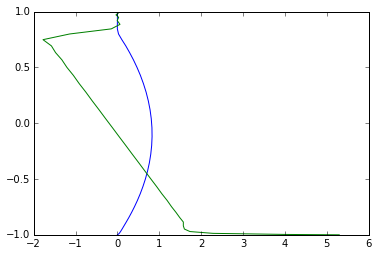

In [20]:
uProfile1 = vF1.getScalar().ifft(withBase=True)[0,:]
y1,DM1 = chebdif(vF1.N,1)
D1 = DM1[:,:,0]
plt.plot(uProfile1,y1)
plt.plot(np.dot(D1,uProfile1),y1)
plt.show()

47
(47,)


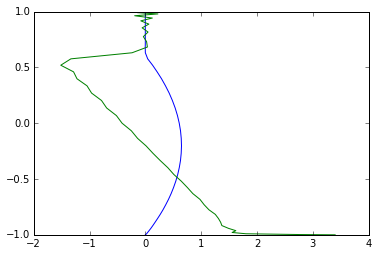

In [18]:
uProfile = vF.getScalar().ifft(withBase=True)[0,:]
print(vF.N)
print(uProfile.shape)
from pseudo import chebdif
import matplotlib.pyplot as plt
%matplotlib inline
y,DM = chebdif(vF.N,1)
D = DM[:,:,0]
plt.plot(uProfile,y)
plt.plot(np.dot(D,uProfile),y)
plt.show()

fNorm is  {'a': 150.0, 'fnorm': 7.484212645501245e-15, 'b': 0.0, 'Re': 1000.0, 'eps': 0.01, 'g': 1.5}
Printed physical field to file finalPlots/wavyE2.0G1.0Re1000.dat
printed to finalPlots/wavyE2.0G1.0Re1000.dat


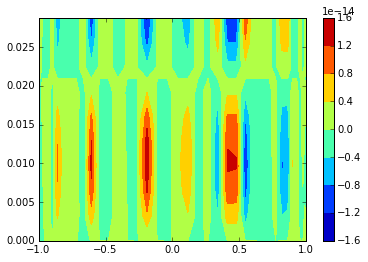

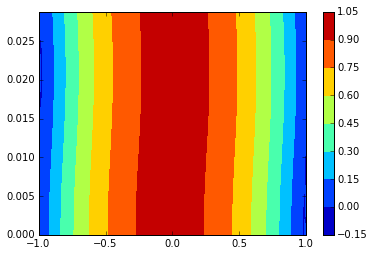

In [3]:
from flowFieldWavy import *
from pseudo import chebdif
import matplotlib.pyplot as plt
%matplotlib inline

xArr = np.arange(0.,0.032,0.0032)
vF,pF,fNorm = mapData2ff(eps = 0.01,g = 1.5,Re=1000.,theta=0)
divField = vF.div().getPhysical(xLoc=xArr)[0,:,0].reshape((10,vF.N))


printName = 'finalPlots/wavyE'+str(round(-np.log10(0.01),2))+'G'+str(round(1.0,2))+'Re'+str(int(1000.))+'.dat'
print('fNorm is ',fNorm)
vF.printPhysicalPlanar(pField=pF, fName=printName,withBase=True)
print('printed to',printName)

y = chebdif(vF.N,1)[0]
plt.contourf(y,np.arange(0.,0.032,0.0032),divField)
plt.colorbar()
plt.show()

plt.contourf(y,xArr, vF.getScalar(nd=0).getPhysical(xLoc=xArr,withBase=True)[0,:,0].reshape(10,vF.N))
plt.colorbar();plt.show()

In [2]:
vF.view4d().flowDict

{'K': 0,
 'L': 8,
 'M': 0,
 'N': 65,
 'Re': 1000.0,
 'alpha': 100.0,
 'beta': 0.0,
 'eps': 0.01,
 'isPois': 1,
 'lOffset': 0.0,
 'mOffset': 0.0,
 'nd': 3,
 'noise': 0.0,
 'omega': 0.0}

In [3]:
div2 = vF.getScalar(nd=0).ddx() + vF.getScalar(nd=1).ddy()
print(vF.getScalar(nd=0).ddX().ifft(xLoc=0.01) )
print(vF.getScalar(nd=0).ddxzYcomp().ifft(xLoc=0.01))
u = vF.getScalar(nd=0)

[[  1.13729875e-16  -2.10202156e-02   2.62632690e-03   2.34896755e-02
    4.94840650e-01   1.99234573e+00   3.23968796e+00   3.31712880e+00
    3.19166083e+00   3.08672679e+00   3.00521635e+00   2.92467301e+00
    2.83339589e+00   2.74164378e+00   2.63644168e+00   2.53208014e+00
    2.41472681e+00   2.29837128e+00   2.17012641e+00   2.04290502e+00
    1.90492908e+00   1.76816976e+00   1.62168096e+00   1.47680943e+00
    1.32311594e+00   1.17162266e+00   1.01211655e+00   8.55542143e-01
    6.91683342e-01   5.31607440e-01   3.64905813e-01   2.02935481e-01
    3.49330677e-02  -1.27309961e-01  -2.95055961e-01  -4.55949303e-01
   -6.21882528e-01  -7.79818447e-01  -9.42397878e-01  -1.09580027e+00
   -1.25351225e+00  -1.40085641e+00  -1.55222227e+00  -1.69205969e+00
   -1.83563556e+00  -1.96662814e+00  -2.10099101e+00  -2.22196120e+00
   -2.34567467e+00  -2.45567436e+00  -2.56724307e+00  -2.66560040e+00
   -2.76352570e+00  -2.84959965e+00  -2.93302327e+00  -3.00383446e+00
   -3.07192431e+00  

In [8]:
dudx = vF.getScalar(nd=0).ddx()
dudx1 = vF.getScalar(nd=0).ddX()
duTrun = dudx.slice(L=2,N=30)
duTrun1 = dudx1.slice(L=2,N=30)

In [6]:
type(vF)

flowFieldWavy.flowFieldWavy

In [11]:
duTrun.ifft(xLoc=0.01)-duTrun1.ifft(xLoc=0.01)

array([[ 3.58089447,  3.70996197,  1.83697004, -0.05317315, -0.04319571,
        -0.03434435, -0.03451189, -0.03489031, -0.03540757, -0.03600115,
        -0.03657905, -0.03704377, -0.03731684, -0.03735745, -0.03717121,
        -0.03680751, -0.03634669, -0.03588087, -0.03549341, -0.03524195,
        -0.03514861, -0.03519795, -0.03534032, -0.03549604, -0.03558548,
        -0.03883147, -0.0508344 ,  0.14872388, -1.4960472 , -2.94157993]])

## Streamwise averaging of streamwise velocity and its wall-normal derivative

In [56]:
# Run the first block of code to import modules

# Define a geometry and flow condition
eps = 0.1; g=1.5; Re=1000.; theta=0

# Read flowfield from database
#vF, pF, fNorm = mapData2ff(eps=eps,g=g,Re=Re,theta=theta)
# Or run a case as needed
vF, pF, fNorm , flg = runMATLAB(g=g, eps=eps, theta=0, Re=Re, N=80,n=13, multi=True)


alpha is: 15.0


In [75]:
1-np.sqrt(1.5*vF.flux(withBase=True))

0.25253512258844169

0.0 0.2
0.0199466200228 0.191114561157
0.0398932400456 0.165247754863
0.0598398600684 0.124697960372
0.0797864800912 0.0730682048733
0.099733100114 0.0149460187173
0.119679720137 -0.0445041867913
0.13962634016 -0.1
0.159572960182 -0.146610374366
0.179519580205 -0.18019377358
0.199466200228 -0.197766165245
0.219412820251 -0.197766165245
0.239359440274 -0.18019377358
0.259306060296 -0.146610374366
0.279252680319 -0.1
0.299199300342 -0.0445041867913
0.319145920365 0.0149460187173
0.339092540387 0.0730682048733
0.35903916041 0.124697960372
0.378985780433 0.165247754863
0.398932400456 0.191114561157


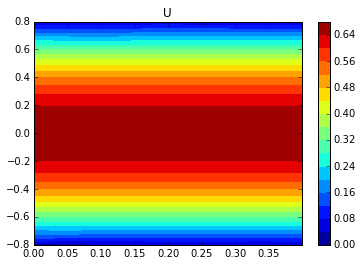

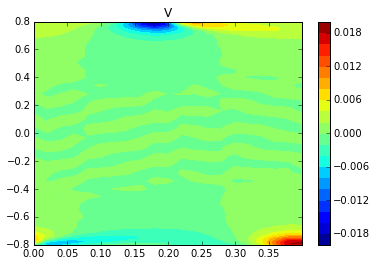

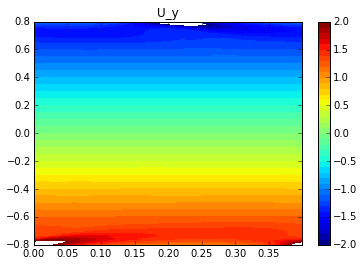

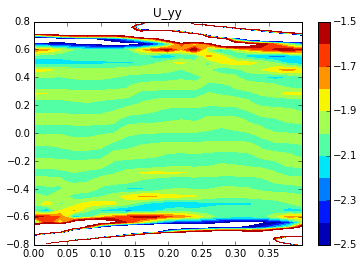

In [57]:
U = vF.getScalar(nd=0).addBase()
V = vF.getScalar(nd=1)
U_y = U.ddy()
U_yy = U.ddy2()
yCheb = chebdif(vF.N,1)[0]

# We'll do the plotting at these streamwise locations:
lda = 2.*np.pi*eps/g     # Wavelength
xArr = np.arange(0., lda, lda/21.)

# Now, I need to decide on a set of nodes to interpolate U, U_y, and U_yy on.
# First, defining bottom and top surfaces.
yBottom = -1.+ 2.*eps*np.cos(g/eps*xArr)
yTop = 2.+yBottom
ySurf = 2.*eps*np.cos(g/eps*xArr)

# Nodes for interpolation are these: cheb nodes spread between -1+2*eps and 1-2*eps, which is the region between the crests
yInter = (1.+yCheb)*(1.-2.*eps)

# Defining x and y grids
xGrid = np.tile(xArr.reshape(xArr.size,1),(1,vF.N))
yGrid = np.tile((yInter-1.+2.*eps).reshape(1,vF.N),(xArr.size,1))
UGrid = np.zeros(xGrid.shape)
VGrid = UGrid.copy()
U_yGrid = UGrid.copy()
U_yyGrid = UGrid.copy()

# Calculating U, U_y, and U_yy on the above grids. flowField methods ifft() and getPhysical reference 'y' from the bottom wall
#     I need to account for this
for k in range(xArr.size):
    print(xArr[k],ySurf[k])
    UGrid[k] = U.getPhysical(xLoc=xArr[k], yLoc = yInter-ySurf[k]+2.*eps-1.)[0,0,0]
    VGrid[k] = V.getPhysical(xLoc=xArr[k], yLoc = yInter-ySurf[k]+2.*eps-1.)[0,0,0]
    U_yGrid[k] = U_y.getPhysical(xLoc=xArr[k], yLoc = yInter-ySurf[k]+2.*eps-1.)[0,0,0]
    U_yyGrid[k] = U_yy.getPhysical(xLoc=xArr[k], yLoc = yInter-ySurf[k]+2.*eps-1.)[0,0,0]

plt.contourf(xGrid,yGrid,UGrid,20)
plt.title('U');plt.colorbar();plt.show()

plt.figure()
plt.contourf(xGrid,yGrid,VGrid,20)
plt.title('V');plt.colorbar();plt.show()

plt.figure()
plt.contourf(xGrid,yGrid,U_yGrid,levels=np.arange(-2.,2.1,0.1))
plt.title('U_y');plt.colorbar();plt.clim([-2.,2.]);plt.show()

plt.figure()
plt.contourf(xGrid,yGrid,U_yyGrid,levels = np.arange(-2.5,-1.4,0.1))
plt.title('U_yy');plt.colorbar();plt.show()

## Continued in next block of code

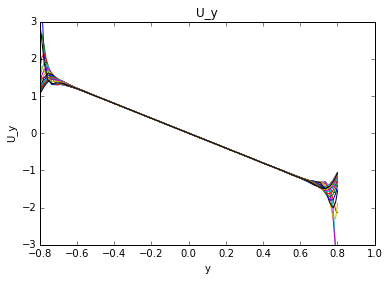

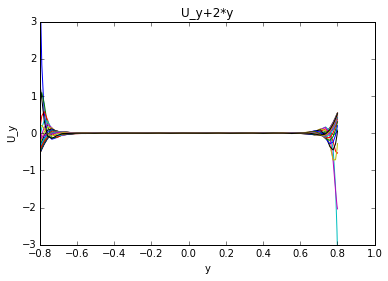

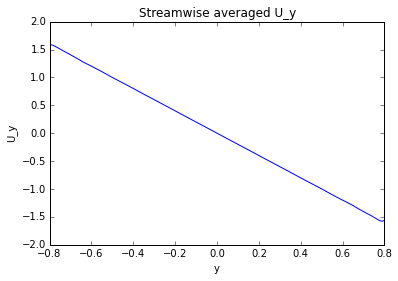

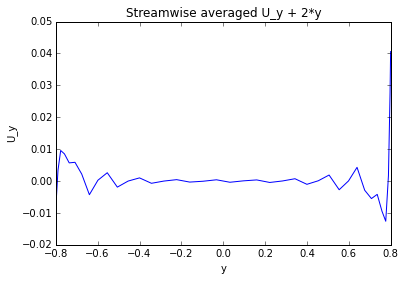

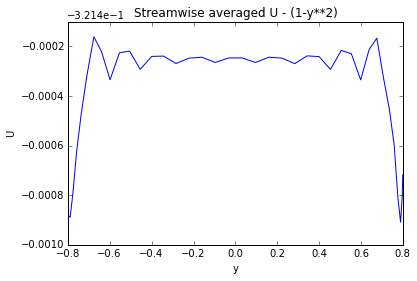

In [79]:
# Plot U_y at a few streamwise locations
plt.figure()
for k in np.arange(0,xArr.size):
    plt.plot(yGrid[k],U_yGrid[k])
plt.title('U_y');plt.xlabel('y');plt.ylim([-3.,3.]);plt.ylabel('U_y');plt.show()

plt.figure()
# The linear U_y profile would be U_y = -2y
for k in np.arange(0,xArr.size):
    plt.plot(yGrid[k],U_yGrid[k]+2.*yGrid[k])
plt.title('U_y+2*y');plt.xlabel('y');plt.ylim([-3.,3.]);plt.ylabel('U_y');plt.show()

U_yMean = np.mean(U_yGrid,axis=0)

plt.figure()
plt.plot(yInter-0.8, U_yMean)
plt.title('Streamwise averaged U_y'); plt.xlabel('y'); plt.ylabel('U_y'); plt.xlim(-0.8,0.8); plt.show()

plt.figure()
plt.plot(yInter-0.8, U_yMean+2.*(yInter-0.8))
plt.title('Streamwise averaged U_y + 2*y'); plt.xlabel('y'); plt.ylabel('U_y'); plt.xlim(-0.8,0.8); plt.show()

UMean = np.mean(UGrid,axis=0)
plt.figure()
plt.plot(yInter-0.8, (UMean-1.+(yInter-0.8)**2))
plt.title('Streamwise averaged U - (1-y**2)'); plt.xlabel('y'); plt.ylabel('U'); plt.xlim(-0.8,0.8);  plt.show()

In [92]:
1.-(1.5*vF.flux(withBase=True))**(1./3.)

0.17637941293763559

In [91]:
Ub = vF.getScalar(nd=0).addBase().intY().ifft()[0,0]/1.6
print(1.-np.sqrt(1.5*Ub))

0.164308861657
